# Parameter Estimation Using Bilby

## Generating the Waveform Using Bilby

In [1]:
from __future__ import division, print_function
import numpy as np
import math
import bilby
import matplotlib.pyplot as plt

#Definitions of lambda Functions

data = np.genfromtxt('/home/abhi/Desktop/Fit_tables/fitvalues.csv',delimiter=',',skip_header=1,usecols=(2,3,4))

n=0.8
def lamda_k(k,lambda_0):
    gnk = math.gamma(k+ (10/(3-n)))/(math.gamma(10/(3-n)))
    a1,a2,a3 = data[:,k-1]
    x = lambda_0**(-1/5)
    return gnk* lambda_0*(1+ a1*x+ a2*x**2 + a3*x**3)
    
    

def lambda_of_lambda0(lambda0,m0,m):
    x = (1-(m/m0))
    a1,a2,a3 = np.array([lamda_k(j,lambda0) for j in [1,2,3]])
    return lambda0+ x*a1 + (a2/2)*x**2 + (a3/6)*x**3
    



In [2]:

#duration- Length of Data in Seconds

#Sampling Frequency- Number of data points per seconds generated by the detector. Usually the detector outputs
#16000 points per second

# 1/sampling_frequency gives the time between successive outputs.

duration = 4
sampling_frequency = 2048.

# Specify the output directory and the name of the simulation.
outdir = 'outdir'
label = 'BNS_realpsd_1'
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility
np.random.seed(2000)


Setting up the Priors and the injection parameters

In [ ]:
parameters = dict(
    mass_1=1.5,mass_2=1.6,a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.1, luminosity_distance=40., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108,lambda_0_0 =200)

priors = bilby.core.prior.PriorDict()
priors['lambda_0_0'] = bilby.core.prior.Uniform(minimum=100, maximum = 300,name = 'lambda_0_0', latex_label='$\lambda_0^0$')
priors['mass_1'] = bilby.core.prior.Uniform(minimum=1.3, maximum = 1.8,name = 'mass_1', latex_label='$m_1$')
priors['mass_2'] =  bilby.core.prior.Uniform(minimum=1.3, maximum = 1.8,name = 'mass_2', latex_label='$m_2$')
priors['luminosity_distance'] = bilby.core.prior.DeltaFunction(peak=parameters['luminosity_distance'],name='luminosity_distance',latex_label='D',unit='Mpc')
priors['geocent_time'] = bilby.core.prior.Uniform(
    minimum=parameters['geocent_time'] - 1,
    maximum=parameters['geocent_time'] + 1,
    name='geocent_time', latex_label='$t_c$', unit='$s$')
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl','theta_jn', 'psi', 'ra',
            'dec', 'geocent_time','phase']:
    priors[key] = parameters[key]
 

We now define our conversion functions to converted the parameter we want to sample $\lambda_0^0$ into parameters that go into the waveform generators.

In [3]:
   
def conversion_function(param):
    converted_parameters = param.copy()
    added_keys = list()
    z = 0.01
    m1 = param['mass_1']/(1+z)
    m2 = param['mass_2']/(1+z)
    lambda00 = param['lambda_0_0']
    converted_parameters['lambda_1'] = lambda_of_lambda0(lambda00,1.4,m1)
    converted_parameters['lambda_2'] = lambda_of_lambda0(lambda00,1.4,m2)
    added_keys+= ['lambda_1','lambda_2']
    return converted_parameters,added_keys
    
# Fixed arguments passed into the source model
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2_NRTidal',
                          reference_frequency=50.)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=conversion_function,
    waveform_arguments=waveform_arguments)

23:05 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: __main__.conversion_function


We have to now set up the detectors. Bilby by default sets it to desgin sensitivity we need to set it from GWTC-1 catalog.

In [4]:
datapsd=np.loadtxt('/home/abhi/Projects/Data from GW Events/GWTC1_PSDs/GWTC1_GW170817_PSDs.dat')

farray=datapsd[:,0]
h1psd = datapsd[:,1]
l1psd= datapsd[:,2]
v1psd = datapsd[:,3]



psd1 = bilby.gw.detector.PowerSpectralDensity(frequency_array=farray, psd_array=h1psd)
psd2 = bilby.gw.detector.PowerSpectralDensity(frequency_array=farray, psd_array=l1psd)
psd3 = bilby.gw.detector.PowerSpectralDensity(frequency_array=farray, psd_array=v1psd)


detectors = list([0,0,0])


detectors[0] = bilby.gw.detector.Interferometer(name ='H1', power_spectral_density= psd1
                                           , minimum_frequency=20.0, maximum_frequency=2048.0, 
                                           length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, 
                                           elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994,
                                           xarm_tilt=-0.0006195, yarm_tilt=1.25e-05 )
detectors[1] = bilby.gw.detector.Interferometer(name='L1', power_spectral_density=psd2,
                                           minimum_frequency=20.0, maximum_frequency=2048.0, length=4.0, 
                                           latitude=30.562894333333332, longitude=-90.77424038888887, 
                                           elevation=-6.574, xarm_azimuth=197.7165, 
                                           yarm_azimuth=287.7165, xarm_tilt=0.0, yarm_tilt=0.0)
detectors[2] = bilby.gw.detector.Interferometer(name='V1', power_spectral_density=psd3, 
                                           minimum_frequency=20.0, maximum_frequency=2048.0, 
                                           length=3.0, latitude=43.631414472222225, longitude=10.504496611111112, 
                                           elevation=51.884, xarm_azimuth=70.56740000000002, 
                                           yarm_azimuth=160.5674, xarm_tilt=0.0, yarm_tilt=0.0)

In [6]:
for interferometer in detectors:
    interferometer.set_strain_data_from_power_spectral_density(
        sampling_frequency=sampling_frequency, duration=duration)
    interferometer.inject_signal(
        parameters=parameters, waveform_generator=waveform_generator)


/home/abhi/anaconda3/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
23:06 bilby WARNING : Injecting signal outside segment, start_time=0, merger time=1126259642.413.
23:06 bilby INFO    : Injected signal in H1:
23:06 bilby INFO    :   optimal SNR = 16.06
23:06 bilby INFO    :   matched filter SNR = 17.68-1.07j
23:06 bilby INFO    :   mass_1 = 1.5
23:06 bilby INFO    :   mass_2 = 1.6
23:06 bilby INFO    :   a_1 = 0.4
23:06 bilby INFO    :   a_2 = 0.3
23:06 bilby INFO    :   tilt_1 = 0.5
23:06 bilby INFO    :   tilt_2 = 1.0
23:06 bilby INFO    :   phi_12 = 1.7
23:06 bilby INFO    :   phi_jl = 0.1
23:06 bilby INFO    :   luminosity_distance = 40.0
23:06 bilby INFO    :   theta_jn = 0.4
23:06 bilby INFO    :   psi = 2.659
23:06 bilby INFO    :   phase = 1.3
23:06 bilby INFO    :   geocent_time = 1126259642.413
23:06 bilby 

In [7]:
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=detectors, waveform_generator=waveform_generator,priors=priors)


In [8]:
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty',nlive=1000,dlogz=0.1,
    injection_parameters=parameters, outdir=outdir,
    label=label,conversion_function=bilby.gw.conversion.generate_all_bns_parameters)

23:07 bilby INFO    : Running for label 'BNS_realpsd', output will be saved to 'outdir'
23:07 bilby INFO    : Using lal version 6.21.0
23:07 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.69;Id: c6afb0789517073ea7423d2422b1ba844a050ef9;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
23:07 bilby INFO    : Using lalsimulation version 1.10.1
23:07 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.69;Id: c6afb0789517073ea7423d2422b1ba844a050ef9;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
23:07 bilby INFO    : Search parameters:
23:07 bilby INFO    :   lambda_0_0 = Uniform(minimum=100, maximum=300, name='lambda_0_0', latex_label='$\\lambda_0^0$', unit=None, boundary=None)
23:07 bilby INFO    :   mass_1 = Uniform(minimum=1.3, maximum=1.8, name='mass_1', latex_label='$m_1$', unit=None, boundary=None)
23:07 bilby INFO    :   mass_2 = Uniform(minimum=1.3, maximum=1.8, name='mass_2', late

0it [00:00, ?it/s]

23:07 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f4b5c424190>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
23:07 bilby INFO    : Checkpoint every check_point_delta_t = 600s
23:07 bilby INFO    : Using dynesty version 1.0.1
23:07 bilby INFO    : Using the bilby-implemented rwalk sam

3821it [10:13,  1.11s/it, bound:79 nc:202 ncall:9.3e+04 eff:4.1% logz-ratio=-277.46+/-0.11 dlogz:666.379>0.1]

23:17 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle


4573it [20:19,  1.55it/s, bound:221 nc:113 ncall:1.9e+05 eff:2.5% logz-ratio=-230.92+/-0.13 dlogz:619.172>0.1]

23:27 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle


5463it [30:26,  1.55it/s, bound:369 nc:101 ncall:2.8e+05 eff:2.0% logz-ratio=-72.63+/-0.14 dlogz:461.534>0.1] 

23:37 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle


6352it [40:33,  1.55it/s, bound:518 nc:101 ncall:3.7e+05 eff:1.7% logz-ratio=82.42+/-0.14 dlogz:306.351>0.1] 

23:48 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle


7241it [50:36,  1.56it/s, bound:666 nc:101 ncall:4.6e+05 eff:1.6% logz-ratio=219.45+/-0.15 dlogz:169.750>0.1]

23:58 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle


8141it [1:00:43,  1.41it/s, bound:816 nc:101 ncall:5.5e+05 eff:1.5% logz-ratio=310.21+/-0.15 dlogz:78.023>0.1]

00:08 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle


9061it [1:10:52,  1.45it/s, bound:969 nc:101 ncall:6.4e+05 eff:1.4% logz-ratio=353.76+/-0.15 dlogz:33.515>0.1]

00:18 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle


9931it [1:21:02,  1.57it/s, bound:1114 nc:101 ncall:7.3e+05 eff:1.4% logz-ratio=371.66+/-0.15 dlogz:14.778>0.1]

00:28 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle


10811it [1:31:11,  1.59it/s, bound:1261 nc:101 ncall:8.2e+05 eff:1.3% logz-ratio=379.08+/-0.15 dlogz:6.475>0.1] 

00:38 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle
00:38 bilby INFO    : Writing 212 current samples to outdir/BNS_realpsd_samples.dat


11701it [1:41:18,  1.53it/s, bound:1409 nc:101 ncall:9.1e+05 eff:1.3% logz-ratio=381.84+/-0.15 dlogz:2.880>0.1]

00:48 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle
00:48 bilby INFO    : Writing 483 current samples to outdir/BNS_realpsd_samples.dat


12581it [1:51:28,  1.51it/s, bound:1556 nc:101 ncall:1.0e+06 eff:1.3% logz-ratio=383.06+/-0.15 dlogz:1.115>0.1]

00:59 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle
00:59 bilby INFO    : Writing 1180 current samples to outdir/BNS_realpsd_samples.dat


13451it [2:01:41,  1.34it/s, bound:1701 nc:101 ncall:1.1e+06 eff:1.2% logz-ratio=383.57+/-0.15 dlogz:0.417>0.1]

01:09 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle
01:09 bilby INFO    : Writing 2674 current samples to outdir/BNS_realpsd_samples.dat


14241it [2:11:51,  1.41it/s, bound:1833 nc:101 ncall:1.2e+06 eff:1.2% logz-ratio=383.76+/-0.15 dlogz:0.176>0.1]

01:19 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle
01:19 bilby INFO    : Writing 2697 current samples to outdir/BNS_realpsd_samples.dat


14779it [2:18:46,  1.35it/s, bound:1922 nc:101 ncall:1.2e+06 eff:1.2% logz-ratio=383.83+/-0.15 dlogz:0.100>0.1]

01:26 bilby INFO    : Written checkpoint file outdir/BNS_realpsd_resume.pickle
01:26 bilby INFO    : Writing 2634 current samples to outdir/BNS_realpsd_samples.dat


14779it [2:18:57,  1.77it/s, bound:1922 nc:  1 ncall:1.2e+06 eff:1.3% logz-ratio=383.93+/-0.15 dlogz:0.000>0.1]



01:26 bilby INFO    : Sampling time: 2:18:37.367918
01:26 bilby INFO    : Generating sky frame parameters.


100%|██████████| 15779/15779 [00:06<00:00, 2437.36it/s]


01:28 bilby INFO    : Computing SNRs for every sample.


100%|██████████| 15779/15779 [01:35<00:00, 165.33it/s]


01:30 bilby INFO    : Summary of results:
nsamples: 15779
ln_noise_evidence: -12393.147
ln_evidence: -12009.219 +/-  0.151
ln_bayes_factor: 383.928 +/-  0.151



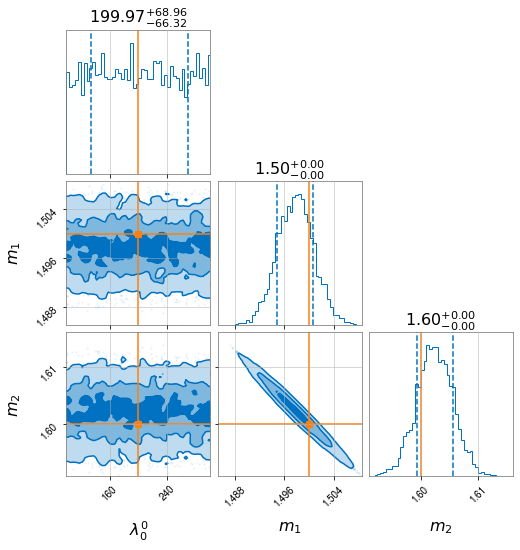

In [9]:
result.plot_corner()